# LSTM

장단기 메모리 네트워크(Long Short-Term Memory, LSTM)는 순환 신경망(RNN)의 한 종류로, 기울기 소실 문제를 해결하기 위해 설계되었습니다. LSTM은 긴 시퀀스에서의 의존성을 더 잘 학습할 수 있어, 언어 모델링, 번역, 음성 인식 등의 작업에서 효과적입니다.


<br>

- 셀 상태: LSTM은 은닉 상태 외에 셀 상태를 추가로 사용하여 장기 정보를 저장하고 전달합니다.
- 게이트: 정보를 선택적으로 업데이트하고 전달하기 위해 입력 게이트, 삭제 게이트, 출력 게이트를 사용합니다.

구조
- 입력 게이트: 새로운 정보를 셀 상태에 얼마나 반영할지 결정합니다.
- 삭제 게이트: 이전 셀 상태에서 얼마나 정보를 유지할지 결정합니다.
- 출력 게이트: 현재 셀 상태에서 얼마나 정보를 출력할지 결정합니다.

## 1. 탑승객 수 예측

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [13]:
data_df = pd.read_csv('data/airline-passengers.csv')
print(data_df.head(10))

FileNotFoundError: [Errno 2] No such file or directory: 'data/airline-passengers.csv'

In [9]:
passengers = data_df['Passengers'].values.astype(float)
plt.plot(passengers)
plt.show()


NameError: name 'data_df' is not defined

In [ ]:
def scaling_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)] # 슬라이싱 x, y 분배
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(passengers.reshape(-1, 1))

seq_length = 4
x, y = scaling_window(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
from sklearn.model_selection import train_test_split
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2)
trainX[:5], trainY[:5]

(tensor([[[0.1544],
          [0.1120],
          [0.0811],
          [0.1197]],
 
         [[0.1274],
          [0.1274],
          [0.1042],
          [0.0560]],
 
         [[0.2201],
          [0.2432],
          [0.2664],
          [0.2027]],
 
         [[0.2413],
          [0.2683],
          [0.3089],
          [0.3243]],
 
         [[0.0695],
          [0.0792],
          [0.0888],
          [0.1429]]]),
 tensor([[0.1293],
         [0.0193],
         [0.1680],
         [0.2568],
         [0.1139]]))

In [ ]:
# data의 shape를 확인
input_size = 1 # input data에 의해 결정
hidden_size = 32
num_layers = 2

num_classes = 1 # 회귀 1
x = trainX[:10].view(-1, seq_length, input_size)
print(x.shape)
lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
fc = nn.Linear(hidden_size, num_classes)

h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
c_0 = torch.zeros(num_layers, x.size(0),hidden_size)
print(h_0.size(), c_0.size())
_, (h_out, _) = lstm(x, (h_0, c_0))
print(h_out.size())
h_out = h_out[-1]
print(h_out.size())
out = fc(h_out)
print(out.size())

torch.Size([10, 4, 1])
torch.Size([2, 10, 32]) torch.Size([2, 10, 32])
torch.Size([2, 10, 32])
torch.Size([10, 32])
torch.Size([10, 1])


In [ ]:
class LSTM_Forecasting(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Forecasting, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, self.seq_length, self.input_size)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        out = self.fc(h_out[-1])

        return out

In [ ]:
# 긍 부정 예측 : BCE
# 문장 생성 : CE
# 시계열 예측 : MSE
# 모델, loss, 학습 방법

In [ ]:
num_epochs = 1000
learning_rate = 0.001

input_size = 1
hidden_size = 32
num_layers = 2

num_classes = 1

lstm = LSTM_Forecasting(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()  # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    lstm.train()
    outputs = lstm(trainX)
    optimizer.zero_grad()

    tr_loss = criterion(outputs, trainY)
    train_losses.append(tr_loss.item())
    tr_loss.backward()

    lstm.eval()
    outputs = lstm(valX)
    val_loss = criterion(outputs, valY)
    valid_losses.append(val_loss.item())

    optimizer.step()
    if epoch % 200 == 0:
      print(f"Epoch: {epoch}, tr loss: {tr_loss.item():1.5f}, val loss: {val_loss.item():1.5f}")

Epoch: 0, tr loss: 0.05827, val loss: 0.04545
Epoch: 200, tr loss: 0.00504, val loss: 0.00323
Epoch: 400, tr loss: 0.00233, val loss: 0.00140
Epoch: 600, tr loss: 0.00162, val loss: 0.00180
Epoch: 800, tr loss: 0.00155, val loss: 0.00194


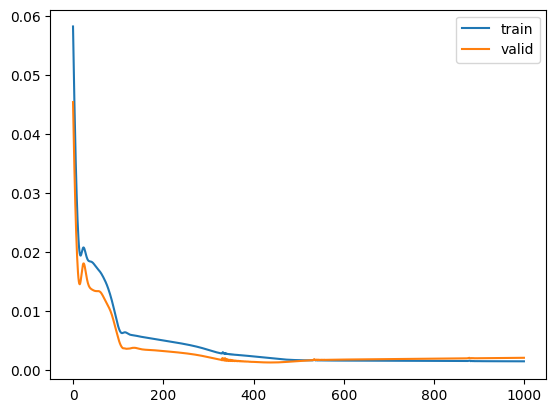

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.show()

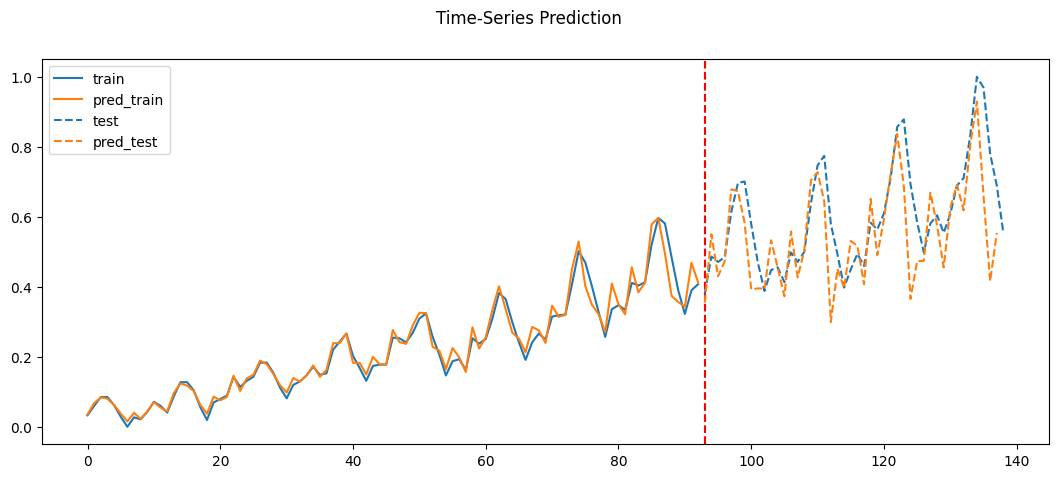

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.figure(figsize=(13, 5))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot[:train_size], 'C0', label='train')
plt.plot(data_predict[1:train_size+1], 'C1', label='pred_train')
plt.plot(list(range(train_size, len(data_predict))), dataY_plot[train_size:], 'C0', label='test', linestyle='--')
plt.plot(list(range(train_size, len(data_predict)-1)), data_predict[train_size+1:], 'C1', label='pred_test', linestyle='--')

plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()

## 2. 스타벅스 주가 예측

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

텍스트 데이터를 처리하기 전에 시계열 데이터를 처리해보겠습니다.

In [ ]:
data=pd.read_csv('data/NLP_data/SBUX.csv') # 스타벅스(SBUX) 주식의 특정 기간 동안의 주가 정보와 거래량을 포함한 금융 데이터
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
1,2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2,2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
3,2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
4,2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900
...,...,...,...,...,...,...,...
248,2020-12-04,101.349998,102.940002,101.070000,102.279999,101.442787,6952700
249,2020-12-07,102.010002,102.220001,100.690002,101.410004,100.579918,4514800
250,2020-12-08,100.370003,101.570000,100.010002,101.209999,100.381554,3911300
251,2020-12-09,101.940002,102.209999,100.099998,100.400002,99.578186,6629900


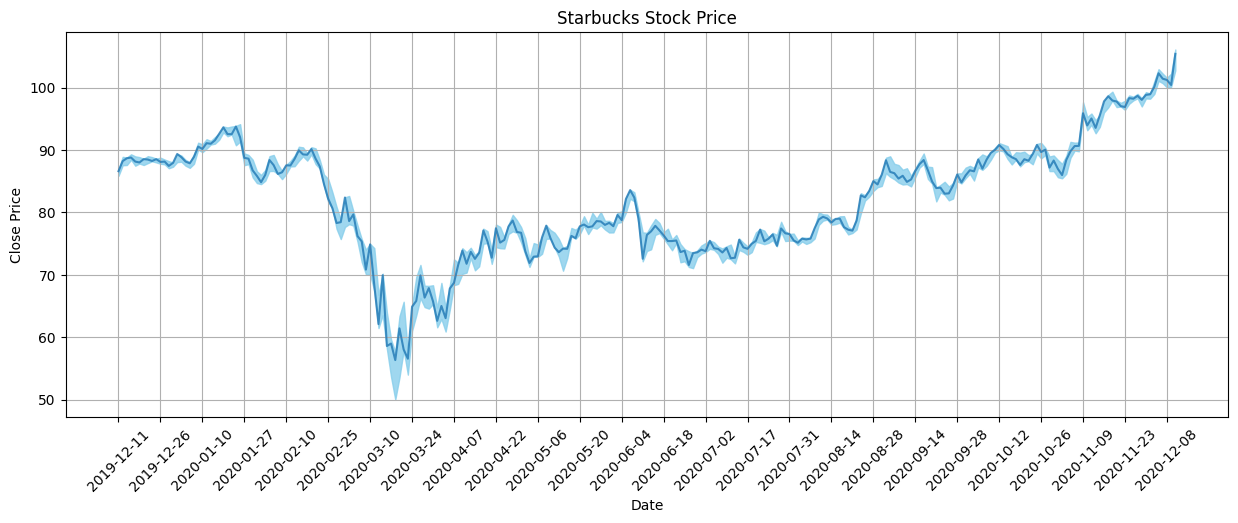

In [ ]:
plt.figure(figsize=(15, 5))
plt.fill_between(data['Date'], data['High'], data['Low'], color='skyblue', alpha=0.8)
plt.plot(data['Date'], data['Close'], color='C0', alpha=0.8)
plt.title('Starbucks Stock Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()
xticks = np.arange(0, len(data), step=10)
plt.xticks(xticks, data['Date'][xticks], rotation=45)
plt.show()

In [ ]:
# 'Date' 열을 datetime 형식으로 변환하여 날짜 데이터를 제대로 처리할 수 있도록
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       253 non-null    datetime64[ns]
 1   Open       253 non-null    float64       
 2   High       253 non-null    float64       
 3   Low        253 non-null    float64       
 4   Close      253 non-null    float64       
 5   Adj Close  253 non-null    float64       
 6   Volume     253 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 14.0 KB


In [ ]:
data.set_index('Date', inplace=True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900
...,...,...,...,...,...,...
2020-12-04,101.349998,102.940002,101.070000,102.279999,101.442787,6952700
2020-12-07,102.010002,102.220001,100.690002,101.410004,100.579918,4514800
2020-12-08,100.370003,101.570000,100.010002,101.209999,100.381554,3911300


In [ ]:
data['Volume'] = data['Volume'].astype(float)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900.0
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100.0
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100.0
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600.0
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900.0
...,...,...,...,...,...,...
2020-12-04,101.349998,102.940002,101.070000,102.279999,101.442787,6952700.0
2020-12-07,102.010002,102.220001,100.690002,101.410004,100.579918,4514800.0
2020-12-08,100.370003,101.570000,100.010002,101.209999,100.381554,3911300.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2019-12-11 to 2020-12-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB


In [ ]:
# 주식의 개장가, 최고가, 최저가, 종가, 조정 종가를 특성으로
X=data[['Open','High','Low','Close','Adj Close']]
X

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288
...,...,...,...,...,...
2020-12-04,101.349998,102.940002,101.070000,102.279999,101.442787
2020-12-07,102.010002,102.220001,100.690002,101.410004,100.579918
2020-12-08,100.370003,101.570000,100.010002,101.209999,100.381554


In [ ]:
# 거래량(Volume)을 종속변수로
y=data[['Volume']]
y

,Volume
Date,
2019-12-11,4921900.0
2019-12-12,10282100.0
2019-12-13,6714100.0
2019-12-16,6705600.0
2019-12-17,7296900.0
...,...
2020-12-04,6952700.0
2020-12-07,4514800.0
2020-12-08,3911300.0


In [ ]:
ms = MinMaxScaler()
ss = StandardScaler()

# 특성을 표준화하여 각 특성값이 균등하게 반영될 수 있도록 조정
X_ss = ss.fit_transform(X)
# 타겟 값을 0과 1 사이의 값으로 변환하여 예측의 안정성과 해석 용이성을 높임
y_ms = ms.fit_transform(y)

In [ ]:
X_ss.shape, X_ss

((253, 5),
 array([[0.46501033, 0.43644414, 0.51542403, 0.49614696, 0.39551683],
        [0.6539359 , 0.66267575, 0.69038876, 0.67120687, 0.56533718],
        [0.65610714, 0.65147637, 0.69453003, 0.72091504, 0.61355736],
        ...,
        [1.99704658, 2.08278598, 1.98139854, 2.07600605, 2.14690131],
        [2.16751399, 2.15446335, 1.99071576, 1.98847658, 2.06024059],
        [2.33798151, 2.58900775, 2.26506846, 2.52770302, 2.5941141 ]]))

In [ ]:
y_ms[:5]

array([[0.11418203],
       [0.31327722],
       [0.18075014],
       [0.18043443],
       [0.20239722]])

In [ ]:
# 시퀀스 데이터를 생성하는 함수
def create_sequences(features, target, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# [0~4], [1~5], [2,6] ....... [(n-5)-1, n-1]

In [ ]:
# 시퀀스 길이를 설정합니다. 예를 들어, 5로 설정합니다.
seq_length = 5
# 시퀀스 데이터 생성
X_seq, y_seq = create_sequences(X_ss, y_ms, seq_length)

In [ ]:
X_seq.shape, y_seq.shape

((248, 5, 5), (248, 1))

In [ ]:
# 학습 데이터와 테스트 데이터로 분할합니다.
train_size = 200
X_train_seq = X_seq[:train_size]
X_test_seq = X_seq[train_size:]

y_train_seq = y_seq[:train_size]
y_test_seq = y_seq[train_size:]

In [ ]:
X_train_seq.shape, X_test_seq.shape, y_train_seq.shape, y_test_seq.shape

((200, 5, 5), (48, 5, 5), (200, 1), (48, 1))

In [ ]:
# 텐서로 변환합니다.
X_train_tensors = torch.tensor(X_train_seq, dtype=torch.float32)
X_test_tensors = torch.tensor(X_test_seq, dtype=torch.float32)

y_train_tensors = torch.tensor(y_train_seq, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test_seq, dtype=torch.float32)

In [ ]:
X_train_tensors.shape, X_test_tensors.shape, y_train_tensors.shape, y_test_tensors.shape

(torch.Size([200, 5, 5]),
 torch.Size([48, 5, 5]),
 torch.Size([200, 1]),
 torch.Size([48, 1]))

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 초기 은닉 상태와 셀 상태 정의
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 순전파
        # output : 모든 타임스텝에서의 은닉 상태(배치, 타임스텝, 은닉상태)
        # hn : 각 층에 대한 마지막 타임스텝의 은닉상태(층, 배치, 은닉상태)
        # cn : 각 층에 대한 마지막 타임스텝의 셀상태(층, 배치, 셀상태)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        # LSTM의 마지막층의 은닉 상태 가져오기
        hn = hn[-1]

        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [ ]:
X_train_tensors.shape

torch.Size([200, 5, 5])

In [ ]:
# 모델의 파라미터 설정
num_classes = 1  # 예측하려는 타겟의 수
input_size = X_train_tensors.shape[2]  # 특성 수
hidden_size = 64  # 숨겨진 레이어의 크기
num_layers = 2  # LSTM 레이어 수

learning_rate = 0.0005

In [ ]:
model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 학습
epochs = 50

train_losses = []
test_losses = []

for i in range(epochs):
    total_loss = 0.0  # 에포크 당 총 손실을 저장할 변수
    model.train()  # 모델을 학습 모드로 설정

    for seq, labels in zip(X_train_tensors, y_train_tensors):
        optimizer.zero_grad()
        seq, labels = seq.unsqueeze(0).to(device), labels.to(device)  # 배치 차원 추가

        y_pred = model(seq)  # 모델 예측

        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        total_loss += single_loss.item()  # 총 손실에 현재 배치의 손실을 추가
    avg_train_loss = total_loss / len(X_train_tensors)  # 평균 훈련 손실 계산
    train_losses.append(avg_train_loss)

    # 검증 손실 계산
    model.eval()  # 모델을 평가 모드로 설정
    total_test_loss = 0.

    with torch.no_grad():
        for test_seq, test_labels in zip(X_test_tensors, y_test_tensors):
            test_seq, test_labels = test_seq.unsqueeze(0).to(device), test_labels.to(device)

            y_val_pred = model(test_seq)
            val_loss = criterion(y_val_pred, test_labels)
            total_test_loss += val_loss.item()

    avg_test_loss = total_test_loss / len(y_test_tensors)  # 평균 검증 손실 계산
    test_losses.append(avg_test_loss)

    if i % 10 == 0:
        print(f'Epoch: {i:3} | Train Loss: {avg_train_loss:.8f} | Test Loss: {avg_test_loss:.8f}')

Epoch:   0 | Train Loss: 0.04091535 | Test Loss: 0.01318982
Epoch:  10 | Train Loss: 0.03039362 | Test Loss: 0.01456469
Epoch:  20 | Train Loss: 0.02354688 | Test Loss: 0.01540941
Epoch:  30 | Train Loss: 0.01945079 | Test Loss: 0.01238249
Epoch:  40 | Train Loss: 0.01707831 | Test Loss: 0.01311665


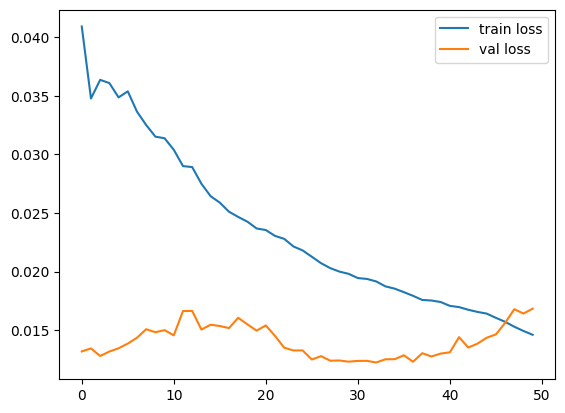

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='val loss')
plt.legend()
plt.show()

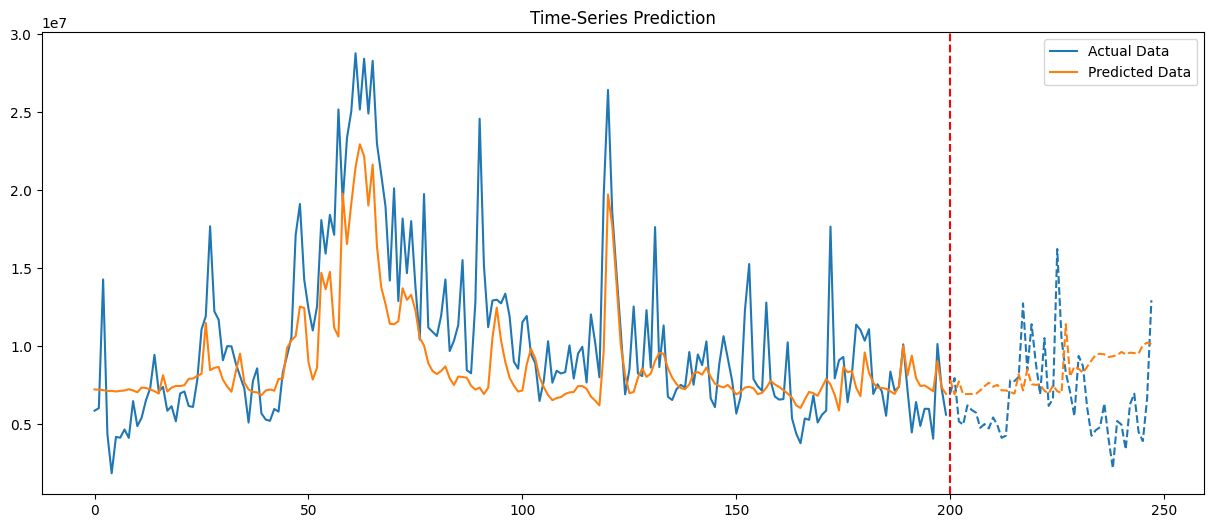

In [ ]:
# 학습 데이터 전체에 대한 예측
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensors.to(device))
    test_predict = model(X_test_tensors.to(device))

# 예측값과 실제값을 numpy 배열로 변환
predicted = train_predict.cpu().numpy()
label_y = y_train_tensors.cpu().numpy()

test_predict = test_predict.cpu().numpy()
test_label_y = y_test_tensors.cpu().numpy()

# 예측값과 실제값을 원래 스케일로 역변환
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

test_predict = ms.inverse_transform(test_predict)
test_label_y = ms.inverse_transform(test_label_y)

# 시각화
plt.figure(figsize=(15,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data', c = 'C0')
plt.plot(predicted, label='Predicted Data', c = 'C1')

plt.plot(list(range(len(label_y), len(label_y) + len(test_label_y))), test_label_y, c='C0', linestyle='--')
plt.plot(list(range(len(label_y), len(label_y) + len(test_label_y))), test_predict, c='C1', linestyle='--')

plt.title('Time-Series Prediction')
plt.legend()
plt.show()